In [2]:
%cd ..

/media/Z/NDT/Transformer_Tabular


In [3]:
import warnings
warnings.filterwarnings('ignore')
from FTTransformer.model import FT_Transformer
from configs import *
import pandas as pd
from yaml.loader import SafeLoader
import typing
import yaml

2023-01-25 05:19:37.585067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 05:19:37.691529: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 05:19:37.695212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-25 05:19:37.695227: I tensorflow/compiler/xla/s

In [4]:
def load_config(path: str) -> typing.Dict:
    with open(path, "r") as f:
        config = yaml.load(f, Loader=SafeLoader)
    return config

In [5]:
hypeparameter = load_config('setting/hyp_fttransformer.yaml')

In [6]:
X_train= pd.read_csv(PATH_TRAIN)
X_val=pd.read_csv(PATH_VAL)
X_test=pd.read_csv(PATH_TEST)

In [7]:
model = FT_Transformer(
   c_feature=CATEGORICAL_FEATURES, 
   n_feature=NUMERIC_FEATURES,
   X_train=X_train,
   hyperparameters=hypeparameter
)

2023-01-25 05:19:45.159730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-25 05:19:45.160304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-25 05:19:45.160728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-25 05:19:45.164710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

## 1. Training

In [8]:
history = model.train(
    train_data=X_train,
    val_data=X_val,
)

>> Training ................
Epoch 1/100
50/51 [============================>.] - ETA: 0s - loss: 0.5285 - output_loss: 0.5285 - output_PR AUC: 0.3627
Epoch 1: saving model to artifact/weights/linear_fft_transform_1674641988.5785031/
51/51 [==============================] - 8s 75ms/step - loss: 0.5263 - output_loss: 0.5263 - output_PR AUC: 0.3666 - val_loss: 0.4114 - val_output_loss: 0.4114 - val_output_PR AUC: 0.6140
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.4037 - output_loss: 0.4037 - output_PR AUC: 0.6154
Epoch 2: saving model to artifact/weights/linear_fft_transform_1674641988.5785031/
51/51 [==============================] - 3s 61ms/step - loss: 0.4037 - output_loss: 0.4037 - output_PR AUC: 0.6154 - val_loss: 0.3741 - val_output_loss: 0.3741 - val_output_PR AUC: 0.6679
Epoch 3/100
50/51 [============================>.] - ETA: 0s - loss: 0.3754 - output_loss: 0.3754 - output_PR AUC: 0.6579
Epoch 3: saving model to artifact/weights/linear_fft_transform_

## 2. Evaluation

In [9]:
model.load_model('artifact/weights/linear_fft_transform_1674641988.5785031/')

In [10]:
model.test_model(test_data=X_test)

32/32 [==============================] - 2s 37ms/step
Test ROC AUC: 0.9001
Test PR AUC: 0.7393
Test Accuracy: 0.8485
F1 score: 0.7796
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.71      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.84      0.85      0.84     16281



In [11]:
import pickle
import matplotlib.pyplot as plt
with open('artifact/history/linear_fft_transform_1674641988.5785031.pkl', 'rb') as f:
    history = pickle.load(f)

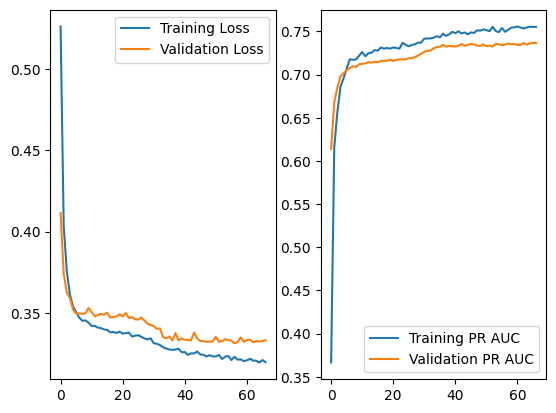

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history['loss'], label='Training Loss')
ax[0].plot(history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(history['output_PR AUC'], label='Training PR AUC')
ax[1].plot(history['val_output_PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()


## 3. Explainable

In [14]:
model.load_model('artifact/weights/linear_fft_transform_1674641988.5785031/')

In [15]:
preds = model.inference(X_test)

32/32 [==============================] - 2s 37ms/step


In [16]:
importances = preds['importances']

In [17]:
linear_importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)
    
    plt.figure(figsize=(15,7))
    ax = imps_sorted.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

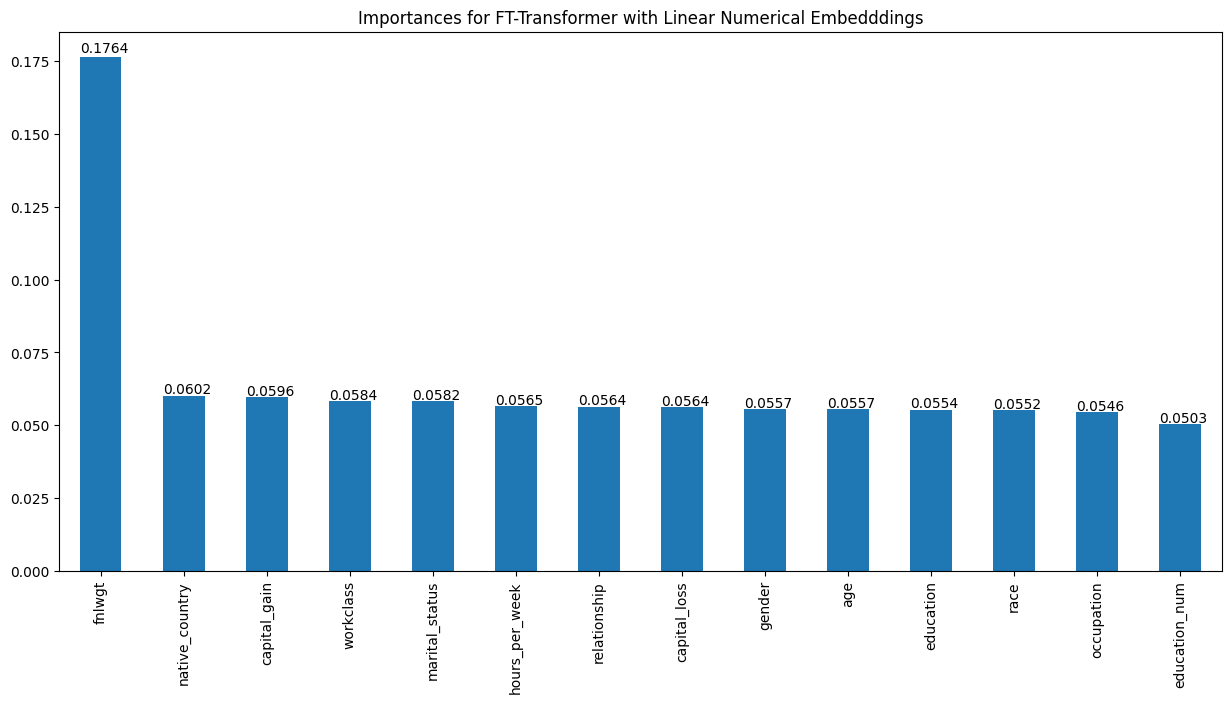

In [19]:
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [20]:
# Largest prediction
max_idx = np.argsort(preds['output'].ravel())[-1]
example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    X_test.iloc[max_idx, :].rename("Example Value")
).head(5)
print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(preds['output'].ravel()[max_idx], 4))}")
display(example_importance_linear)

# Smallest one
min_idx = np.argsort(preds['output'].ravel())[0]
example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    X_test.iloc[min_idx, :].rename("Example Value")
).head(5)
print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(preds['output'].ravel()[min_idx], 4))}")
display(example_importance_linear)

Top 5 contributions to row 9550 which was scored 0.9195


,Importance,Example Value
fnlwgt,0.121683,115892
hours_per_week,0.083337,40
capital_gain,0.071239,0
native_country,0.061806,United-States
workclass,0.058609,Private


Top 5 contributions to row 88 which was scored 0.0028


,Importance,Example Value
fnlwgt,0.097500,228724
native_country,0.068070,United-States
education,0.067502,Some-college
marital_status,0.067083,Never-married
age,0.064054,24


## 4. Inferences

In [21]:
inputs = {
    'age': 25.0,
    'workclass': 'Private',
    'fnlwgt': 226802.0,
    'education': '11th',
    'education_num': 7.0,
    'marital_status': 'Never-married',
    'occupation': 'Machine-op-inspct',
    'relationship': 'Own-child',
    'race': 'black',
    'gender': 'Male',
    'capital_gain': 0.0,
    'capital_loss': 0.0,
    'hours_per_week': 40.0,
    'native_country': 'United-States',
    'income_bracket': ''
}

In [22]:
preds = model.inference(inputs)
score = preds['output']
importance = preds['importances']

1/1 [==============================] - 0s 410ms/step


In [23]:
importances_df = pd.DataFrame(importance[:, :-1], columns = FEATURES)

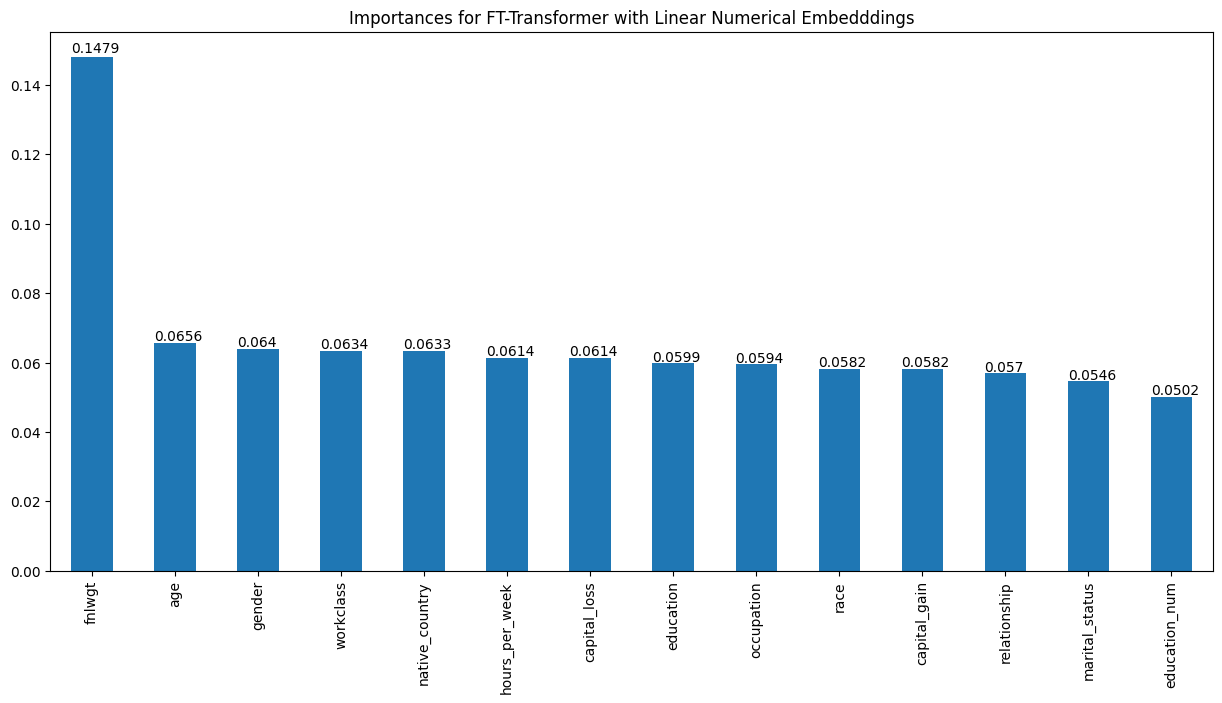

In [24]:
linear_total_importances = get_model_importances(
    importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)